# **Αναγνώριση Προτύπων – Μηχανική Μάθηση Εργασία 2: Μέθοδοι μείωσης διαστάσεων**

### Κυριακόπουλος Βασίλειος 1115201700064

## Εισαγωγή απαραίτητων βιβλιοθηκών:

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

%matplotlib inline

Καθορισμός seed στην numpy για την ντετερμινιστικότητα των τυχαίων της συναρτήσεων:

In [2]:
np.random.seed(17064)

## **Ερώτημα 1:** Προ-επεξεργασία, μείωση διαστάσεων, και οπτικοποίηση και ταξινόμηση εικόνων.

Ορισμός συνάρτησης για φόρτωση των εικόνων:

In [3]:
def loadImages(path):
  # List of 1d image vectors
  images = []
  # Labels for each image(0 for winter, 1 for fall and 2 for spring)
  classes = []
  for imgfile in os.listdir(path):
    # Load the image
    img = cv2.imread(os.path.join(path,imgfile),cv2.IMREAD_COLOR)
    # Convert it from BGR to RGB
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # Resize it to an 100x100
    img = cv2.resize(img,dsize=(100,100))
    # Convert it to a 1d column vector and keep it to the list
    images.append(img.reshape(-1))
    # Retrieve it's correct class from it's filename
    if imgfile[0] == 'W':
      classes.append(0)
    elif imgfile[0] == 'F':
      classes.append(1)
    elif imgfile[0] == 'S':
      classes.append(2)
  # Construct the 30000x30 array of pixels and return it with the corresponding classes
  return np.stack(images,axis=1), classes

Φόρτωση των εικόνων από τον αντίστοιχο φάκελο:

In [4]:
images, classes = loadImages('images')

Ορισμός συνάρτησης που υπολογίζει και προβάλει τις εικόνες στις δύο πρώτες κύριες συνιστώσες (principal
components):

In [5]:
def PCA_ImageSpaceVisualization(X):
  # SVD process
  data = (X - np.mean(X,axis=1,keepdims=True)).T
  U, s, VT = np.linalg.svd(data,full_matrices=False)
  # Calculate the components for every image
  nComponents = 2
  pcs = U * s
  # Scatter plot them
  x = pcs[:,:nComponents].T[0]
  y = pcs[:,:nComponents].T[1]
  fig, ax = plt.subplots(figsize=(20,12))
  ax.scatter(x=x,y=y)
  for i in range(X.shape[1]):
    img = AnnotationBbox(OffsetImage(np.reshape(a=X[:,i],newshape=(100,100,3)),zoom=0.5),(x[i],y[i]))
    ax.add_artist(img)
  # Return the principal components and the singular values for later use
  return pcs, s

Προβολή των εικόνων στις πρώτες δύο κύριες συνιστώσες:

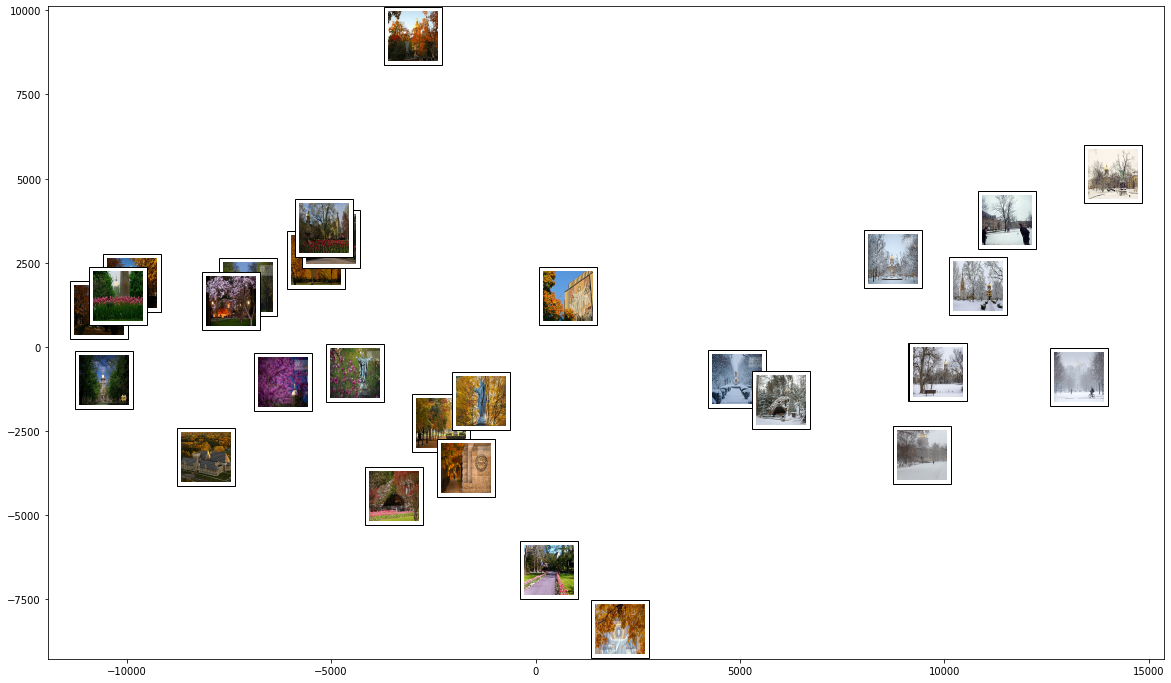

In [6]:
pcs, singular_values = PCA_ImageSpaceVisualization(images)

Απαντήσεις σε κάποιες θεωρητικές ερωτήσεις:

---

* **Τι σημαίνει όταν εικόνες βρίσκονται κοντά σε αυτό το χώρο δύο διαστάσεων που
απεικονίζεται στο παραπάνω plot;**  \\
Σημαίνει ότι μοιάζουν, και φυσικά έχουν παρόμοια χρώματα το οποίο φυσικά συνεπάγεται ότι η απόσταση μεταξύ των χρωμάτων τους θα είναι μικρή και ειδικά στις κύριες συνιστώσες. Γι αυτό τον λόγο εμφανίζονται κοντά μεταξύ τους στο παραπάνω plot. Αυτό φυσικά συμβαίνει κυρίως σε φωτογραφίες που έχουν τραβηχτεί την ίδια εποχή. 

* **Τι σημαίνει όταν εικόνες απέχουν πολύ;** \\
Όταν απέχουν πολύ, σημαίνει ότι τα χρώματά τους διαφέρουν αρκετά και φυσικά και στις δύο πρώτες κύριες συνιστώσες. Αυτό παρατηρούμε ότι συμβαίνει μεταξύ δυο φωτογραφιών όπου η πρώτη έχει τραβηχτεί τον χειμώνα, και η δεύτερη την άνοιξη ή το φθινόπωρο.

* **Μπορούμε
να γενικεύσουμε αυτά τα συμπεράσματα για τον αρχικό χώρο των εικόνων ο οποίος είναι
πολύ μεγάλης διάστασης;** \\
Όσο περισσότερες διαστάσεις χρησιμοποιούμε για να περιγράψουμε μια εικόνα, τόσο μεγαλύτερη ακρίβεια θα έχουμε στην περιγραφή τους. Όμως, δεν πρέπει να το παρακάνουμε διότι από ένα σημείο και μετά η πληροφορία που περιέχουν οι επιπλέον διαστάσεις είναι περιττή, και δεν προσφέρει τίποτα χρήσιμο στον υπολογισμό της απόστασης(διαφοράς) μίας εικόνας από μία άλλη. Επιπλέον, όσο περισσότερες διαστάσεις χρησιμοποιούμε, τόσο μεγαλύτερο σύνολο δεδομένων απαιτείται για να εκφράσουμε τα ίδια συμπεράσματα, αφού οι εικόνες στην μεγάλη διάσταση θα απέχουν πολύ περισσότερο από ότι στην μικρή, και ετσι δεν θα μπορούμε να βγάλουμε εύκολα παρόμοια συμπεράσματα με τον χώρο των δύο διαστάσεων. Ακόμα, την γεωμετρία σε χώρους άνω των τριών διαστάσεων δεν μπορεί να την οπτικοποιήσει και να περιγράψει ο άνθρωπος, το οποίο αποτελεί έναν παραπάνω λόγο για την αδυναμία παρόμοιας σύγκρισης στον αρχικό χώρο(30000 διαστάσεων) των εικόνων.

* **Οι εικόνες που αντιστοιχούν σε μία από τις εποχές τείνουν να ομαδοποιούνται πιο κοντά
από ότι οι υπόλοιπες; Γιατί συμβαίνει αυτό;** \\
Όπως απαντήθηκε και παραπάνω, οι εικόνες που αντιστοιχούν στην ίδια εποχή τείνουν να ομαδοποιούνται πιο κοντά στο παραπάνω plot διότι έχουν παρόμοια χρώματα(ειδικά στις 2 πρώτες κύριες συνιστώσες), το οποίο φυσικά σημαίνει ότι και η μεταξύ τους απόσταση θα είναι μικρή με αποτέλεσμα να απεικονίζονται αρκετά κοντά μεταξύ τους.


Σύγκριση ακρίβειας ταξινόμησης(classification accuracy) του ταξινομητή
πλησιέστερου γείτονα (1-ΝΝ) και του ταξινομητή τριών πλησιέστερων γειτόνων (3-ΝΝ) στο πρόβλημα της αναγνώρισης της εποχής κατά την οποία καταγράφηκε μια εικόνα. \\
Η σύγκριση θα πραγματοποιηθεί χρησιμοποιώντας:


1.   Τις αρχικές μεγάλης διάστασης εικόνες σε μορφή διανύσματος.
2.   Χαρακτηριστικά χαμηλής διάστασης που εξάγαμε από την PCA.

Επίσης, για την μέτρηση της ακρίβειας, θα χρησιμοποιηθεί η τεχνική 5-fold cross validation αναφέροντας την μέση τιμή ακρίβειας από όλα τα πειράματα. Θα χρησιμοποιηθεί ο KNeighborsClassifier της βιβλιοθήκης sklearn.

Ταξινόμηση στα δεδομένα της αρχικής διάστασης με τον 1-NN classifier:

In [7]:
kf = KFold(n_splits=5)
X = images.T
y = np.array(classes)
mean_accuracy = 0
fold = 0
for train_index, test_index in kf.split(X):
  fold+=1
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  nn = KNeighborsClassifier(n_neighbors=1)
  nn.fit(X_train,y_train)
  score = nn.score(X_test,y_test)
  print("Fold",fold,"score: ",score)
  mean_accuracy += score
mean_accuracy /= 5
print("Original dimension 1-NN classifier mean accuracy: ",mean_accuracy)

Fold 1 score:  0.6666666666666666
Fold 2 score:  0.6666666666666666
Fold 3 score:  1.0
Fold 4 score:  1.0
Fold 5 score:  0.6666666666666666
Original dimension 1-NN classifier mean accuracy:  0.7999999999999999


Ταξινόμηση στα δεδομένα της αρχικής διάστασης με τον 3-NN classifier:

In [8]:
kf = KFold(n_splits=5)
X = images.T
y = np.array(classes)
mean_accuracy = 0
fold = 0
for train_index, test_index in kf.split(X):
  fold+=1
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  nn = KNeighborsClassifier(n_neighbors=3)
  nn.fit(X_train,y_train)
  score = nn.score(X_test,y_test)
  print("Fold",fold,"score: ",score)
  mean_accuracy += score
mean_accuracy /= 5
print("Original dimension 3-NN classifier mean accuracy: ",mean_accuracy)

Fold 1 score:  0.6666666666666666
Fold 2 score:  0.6666666666666666
Fold 3 score:  0.8333333333333334
Fold 4 score:  0.8333333333333334
Fold 5 score:  0.6666666666666666
Original dimension 3-NN classifier mean accuracy:  0.7333333333333333


Αφού κάναμε ταξινόμηση στα δεδομένα της αρχικής διάστασης, τώρα θα επιλέξουμε ένα κατάλληλο πλήθος κύριων συνιστωσών από αυτές που υπολογίσαμε προηγουμένως, και στη συνέχεια θα εφαρμόσουμε τις παραπάνω μεθόδους ταξινόμησης στα δεδομένα χαμηλής διάστασης.

Για να προσδιορίσουμε την νέα διάσταση των χαρακτηριστικών, πρέπει αρχικά για κάθε μία από τις συνιστώσες που υπολογίσαμε προηγουμένως, να υπολογίσουμε τον λόγο της εξηγούμενης διακύμανσης της εκάστοτε συνιστώσας σε σχέση με το πλήθος των κυρίων συνιστωσών (explained variance ratio). Για να το κάνουμε αυτό αρκεί να εφαρμόσουμε σε κάθε συνιστώσα τον εξής τύπο: \\
$R_i^2 = \frac{s_i^2}{\sum_js_j^2}$ \\
όπου $s_i$ και $s_j$ είναι οι ιδιάζουσες τιμές (singular values) που προέκυψαν από την μέθοδο της ανάλυσης ιδιαζουσών τιμών (Singular Value Decomposition).

In [9]:
denom = sum([sj ** 2 for sj in singular_values])
explained_variance_ratio = [(si ** 2)/denom for si in singular_values]

Στη συνέχεια, θα εξετάσουμε τον σωρευτικό λόγο της εξηγούμενης διακύμανσης σε σχέση με τον αριθμού των κυρίων συνιστωσών:

[0.4644354360739782, 0.09279368809660468, 0.05887230506244035, 0.0480145675872651, 0.03897304130006184, 0.03279584483895637, 0.027711257095684002, 0.024721917442997947, 0.019832239267253374, 0.01804814037212739, 0.0171262160275734, 0.01576069315044563, 0.01372996213883276, 0.012665840390573023, 0.011748710880450937, 0.010960851376602637, 0.010533757216547056, 0.009890918241126399, 0.009629192882005174, 0.008718297945866725, 0.008657991637608045, 0.007610707727402296, 0.007401414691782799, 0.007370791379080165, 0.006872864176476716, 0.005459761054464325, 0.004881076851429437, 0.004667482339340091, 0.00011503275502291672, 1.164780522201198e-31]
[0.46443544 0.55722912 0.61610143 0.664116   0.70308904 0.73588488
 0.76359614 0.78831806 0.8081503  0.82619844 0.84332465 0.85908535
 0.87281531 0.88548115 0.89722986 0.90819071 0.91872447 0.92861539
 0.93824458 0.94696288 0.95562087 0.96323158 0.97063299 0.97800378
 0.98487665 0.99033641 0.99521748 0.99988497 1.         1.        ]


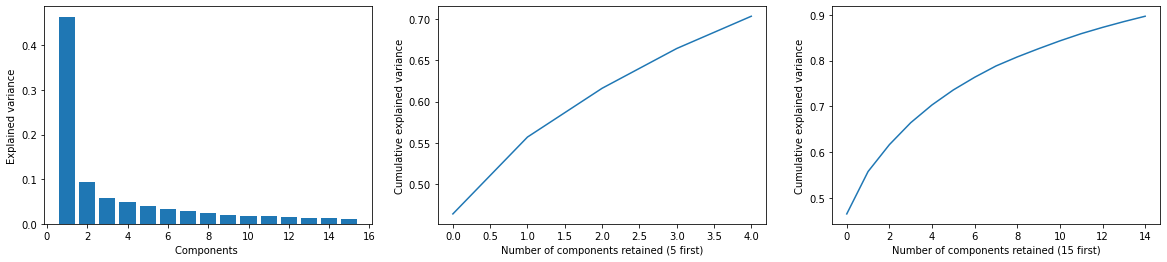

In [10]:
cum_explained_var_ratio = np.cumsum(explained_variance_ratio)
print(explained_variance_ratio)
print(cum_explained_var_ratio)

plt.figure(figsize=(20, 4))
plt.subplot(1,3,1)
components = 15
plt.bar(range(1,components+1),explained_variance_ratio[:components])
plt.xlabel('Components ')
plt.ylabel('Explained variance')

plt.subplot(1,3,2)
plt.plot(cum_explained_var_ratio[:5])
plt.xlabel('Νumber of components retained (5 first)')
plt.ylabel('Cumulative explained variance');

plt.subplot(1,3,3)
plt.plot(cum_explained_var_ratio[:15])
plt.xlabel('Νumber of components retained (15 first)')
plt.ylabel('Cumulative explained variance');

Παρατηρούμε ότι οι 2 πρώτες συνιστώσες έξηγούν περίπου το 56%(46,4% + 9,2%) της διακύμανσης των δεδομένων. Όμως, σύμφωνα με την θεωρία , πρέπει να επιλέξουμε το πλήθος των συνιστωσών τέτοιο ώστε να εξηγεί περίπου το 85-90% της συνολικής διακύμανσης των δεδομένων. Οπότε, σύμφωνα με τα παραπάνω διαγράμματα, **αρκούν οι 14 πρώτες κύριες συνιστώσες** οι οποίες εξηγούν όντως το 90% της συνολικής διακύμανσης των δεδομένων.

Έχοντας επιλέξει το απαιτούμενο πλήθος κυρίων συνιστωσών, θα μελέτήσουμε την  μέση ακρίβεια ταξινόμησης την ταξινομητών 1-NN και 3-NN στα αντίστοιχα δεδομένα χαμηλής διάστασης.

Ταξινόμηση στα δεδομένα χαμηλής διάστασης με τον 1-NN classifier:

In [11]:
kf = KFold(n_splits=5)
X = pcs[:,:14]
y = np.array(classes)
mean_accuracy = 0
fold = 0
for train_index, test_index in kf.split(X):
  fold+=1
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  nn = KNeighborsClassifier(n_neighbors=1)
  nn.fit(X_train,y_train)
  score = nn.score(X_test,y_test)
  print("Fold",fold,"score: ",score)
  mean_accuracy += score
mean_accuracy /= 5
print("Reduced dimension 1-NN classifier mean accuracy: ",mean_accuracy)

Fold 1 score:  0.6666666666666666
Fold 2 score:  0.6666666666666666
Fold 3 score:  0.8333333333333334
Fold 4 score:  1.0
Fold 5 score:  0.6666666666666666
Reduced dimension 1-NN classifier mean accuracy:  0.7666666666666666


Ταξινόμηση στα δεδομένα χαμηλής διάστασης με τον 3-NN classifier:

In [12]:
kf = KFold(n_splits=5)
X = pcs[:,:14]
y = np.array(classes)
mean_accuracy = 0
fold = 0
for train_index, test_index in kf.split(X):
  fold+=1
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  nn = KNeighborsClassifier(n_neighbors=3)
  nn.fit(X_train,y_train)
  score = nn.score(X_test,y_test)
  print("Fold",fold,"score: ",score)
  mean_accuracy += score
mean_accuracy /= 5
print("Reduced dimension 3-NN classifier mean accuracy: ",mean_accuracy)

Fold 1 score:  0.6666666666666666
Fold 2 score:  0.5
Fold 3 score:  1.0
Fold 4 score:  0.8333333333333334
Fold 5 score:  0.6666666666666666
Reduced dimension 3-NN classifier mean accuracy:  0.7333333333333333


Παρατηρούμε ότι η ακρίβεια των 2 ταξινομητών στα δεδομένα μειωμένης διάστασης είναι παρόμοια με αυτή στα δεδομένα της αρχικής διάστασης(λιγάκι χειρότερη βέβαια αλλά σχεδόν ίδια). Αυτό είναι φυσιολογικό εφόσον επιλέξαμε τις κύριες συνιστώσες που περιγράφουν ένα σχετικά μεγάλο ποσοστό (περίπου 90%) της συνολικής διακύμανσης, το οποίο φυσικά σημαίνει ότι διατηρούν και την περισσότερη πληροφορία των εικόνων. Με άλλα λόγια καταφέραμε να εκφράσουμε δεδομένα 30000 διαστάσεων εξίσου ικανοποιητικά με δεδομένα μόλις 14 διαστάσεων!!!

Τέλος να σημειωθεί ότι φυσικά δεν είναι δυνατόν να πετύχουμε μεγαλύτερη ακρίβεια από αυτή των δεδομένων αρχικής διάστασης. 

## **Ερώτημα 2:** Κανονικοποιημένη μη-αρνητική παραγοντοποίηση πινάκων.

Το ζητούμενο πρόβλημα είναι ένα πρόβλημα βελτιστοποίησης με την εξής μορφή: \\
$\min_{A,B}||X - AB||_F^2 + \lambda||A||_F^2$ S.T $A \geq 0,B \geq 0$

Αυτό το πρόβλημα προφανώς δεν έχει λύση σε κλειστή μορφή και συνεπώς πρέπει να λυθεί επαναληπτικά. Άρα για να το λύσουμε, θα ακολουθήσουμε την παρακάτω μεθοδολογία:

Αρχικά, θα ορίσουμε την συνάρτηση σφάλματος του παραπάνω προβλήματος ως εξής: 

$f(A,B) = ||X - AB||_F^2 + \lambda||A||_F^2 = Tr((X - AB)(X - AB)^T) + \lambda Tr(AA^T) = Tr((X - AB)(X^T - (AB)^T)) + \lambda Tr(AA^T) = Tr((X - AB)(X^T - B^TA^T)) + \lambda Tr(AA^T) = 
Tr((X - AB)X^T - (X - AB)B^TA^T) + \lambda Tr(AA^T) = 
Tr(XX^T - ABX^T - XB^TA^T + ABB^TA^T) + \lambda Tr(AA^T) = 
Tr(XX^T) - Tr(ABX^T) - Tr(XB^TA^T) + Tr(ABB^TA^T) + \lambda Tr(AA^T)$

κι έτσι το παραπάνω πρόβλημα ανάγεται στο: 

$min_{A,B}f(A,B)$ S.T $A \geq 0,B \geq 0$ 

δηλαδή στην ελαχιστοποίηση της $f(A,B)$ ως πρός $A$ και $B$ υπό τον περιορισμό της μη-αρνητικότητας αυτών. 

Το επόμενο πράγμα που πρέπει να κάνουμε είναι να ορίσουμε τους πολλαπλασιαστικούς κανόνες ανανέωσης (multiplicative update rules) των μεταβλητών $Α$ και $B$, αφού πρώτα ορίσουμε τις κλήσεις (gradients) της $f$ ως πρός $A$ και $B$. Έχουμε:

$\nabla_Af(A,B) = 0 - (BX^T)^T - XB^T + A(BB^T)^T + ABB^T + \lambda2A = 
- XB^T - XB^T + ABB^T + ABB^T + 2\lambda A \iff \nabla_Af(A,B) = 2\lambda A + 2ABB^T - 2XB^T$

$\nabla_Bf(A,B) = 0 - A^TX - A^TX + A^TAB + A^TAB + 0 \iff \nabla_Bf(A,B) = 2A^TAB - 2A^TX$

Οι κανόνες ανανέωσης των $A$ και $B$ είναι της μορφής: \\
$A_{[t+1]} = A_{[t]} - n_t\nabla_{A_{[t]}}f(A_{[t]},B)$, \\
$B_{[t+1]} = B_{[t]} - n_t\nabla_{B_{[t]}}f(A,B_{[t]})$

όπου η παράμετρος $n_t$ είναι ο ρυθμός ανανέωσης(learning rate ή step size) και καθορίζει το πόσο θα αλλάξει η μεταβλητή σε κάθε βήμα.

Όμως, αυτοί οι κανόνες επανάληψης δεν επιβάλουν την μη-αρνητικότητα των μεταβλητών, επομένως πρέπει να προσδιορίσουμε το step size με τρόπο που εξαρτάται από τα δεδομένα ως εξής:


Για την μεταβλητή $A$, το learning rate και ο κανόνας ανανέωσης γίνονται: \\
$n = \frac{A}{\nabla_Af(A,B)^+} = \frac{A}{\lambda A + ABB^T}$ \\
$A = A - \frac{A}{\lambda A + ABB^T}\circ \nabla_Af(A,B) = 
\frac{A \circ (\lambda A + ABB^T) - A \circ (\lambda A + ABB^T - XB^T)}{\lambda A + ABB^T} = A \circ \frac{XB^T}{\lambda A + ABB^T}$ 

όπου το $\circ$ συμβολίζει το γινόμενο Hadamard και το $+$ συμβολίζει το θετικο μέρος της αντίστοιχης αριθμητικής παράστασης. Επιπλέον, αφόυ πάντα θα ισχύει ότι $\lambda = 0.5$, θεωρήσα ότι θα είναι πάντα θετικό και έβγαλα τον παραπάνω κανόνα ανανέωσης λαμβάνοντας υπόψιν αυτόν τον περιορισμό. Αν όμως το $\lambda$ έπαιρνε και αρνητικές τιμές, θα είχαμε ξεχωριστή περίπτωση και ο παραπάνω κανόνας ανανέωσης θα είχε άλλη μορφή. 

Με παρόμοιο τρόπο, εργαζόμαστε και για την μεταβλητή $B$: \\
$n = \frac{B}{\nabla_Bf(A,B)^+} = \frac{B}{A^TAB}$ \\
$B = B - \frac{B}{A^TAB}\circ \nabla_Bf(A,B) = 
\frac{B\circ (A^TAB) - B\circ (A^TAB - A^TX)}{A^TAB} = 
B\circ \frac{A^TX}{A^TAB}$ \\

Επίσης, η σταθερά 2 αγνοήθηκε αφού μπορεί να ενσωματωθεί στο learning rate.

Συνοψίζοντας, οι κανόνες ανανέωσης για τις μεταβλητές $A$ και $B$ αντίστοιχα είναι: \\
$A_{[t+1]} = A_{[t]} \circ \frac{XB_{[t]}^T}{\lambda A_{[t]} + A_{[t]}B_{[t]}B_{[t]}^T}$ \\
$B_{[t+1]} = B_{[t]}\circ \frac{A_{[t]}^TX}{A_{[t]}^TA_{[t]}B_{[t]}}$

Σημειωτέον ότι εφόσον οι αρχικοί πίνακες είναι μη αρνητικοί, επαγωγικά αποδεικνύεται ότι
ακολουθώντας αυτά τα βήματα προκύπτουν πάντα μη-αρνητικοί πίνακες. 

Τώρα, ας υλοποίησουμε έναν επαναληπτικό αλγόριθμο που να λύνει το παραπάνω πρόβλημα:

In [13]:
# Calculates the squared frobenius norm of (X - AB)
def F_Norm(X,A,B):
  return np.linalg.norm((X - np.dot(A,B)),ord='fro') ** 2

# Multiplicative update rule for A
def update_A(X,A,B,Lambda):
  return A * (np.dot(X,B.T)/(Lambda * A + np.dot(A,np.dot(B,B.T))))

# Multiplicative update rule for B
def update_B(X,A,B):
  return B * (np.dot(A.T,X)/np.dot(A.T,np.dot(A,B)))

def RegNMF(X,k,Lambda,epsilon):
  # X is a d x N matrix. So, first lets extract it's dimensions
  d, N = X.shape

  # Then, let's define our variables
  A = np.random.rand(d,k)
  B = np.random.rand(k,N)
  # Note that np.random.rand() always produces numbers in range [0,1) so we don't have to worry about negative numbers.

  # Calculate initial error
  prev_loss = F_Norm(X,A,B)
  X_norm = np.linalg.norm(X,ord='fro') ** 2
  error = prev_loss/X_norm

  # Start iterations until the error change in 2 consequtive iterations is at most epsilon
  iteration = 1
  while error > epsilon:
    # Update variables
    A = update_A(X,A,B,Lambda)
    B = update_B(X,A,B)
    # Calculate new error
    loss = F_Norm(X,A,B)
    error = (prev_loss - loss)/X_norm
    print("Iteration",iteration,"has reconstruction error",np.sqrt(F_Norm(X,A,B)),"and error change:",error)
    prev_loss = loss
    iteration+=1

  # Final report
  print("RegNMF algorithm took",iteration-1,"iterations to converge with rank =",k,"and reconstruction error =",np.sqrt(F_Norm(X,A,B)))
  # Return final factorization
  return A, B


Τώρα, για να μελετήσουμε την σύγκλιση του παραπάνω αλγορίθμου, θα δημιουργήσουμε έναν τυχαίο 500 x 500 πίνακα ως εξής:

In [14]:
X = np.random.rand(500,500)
print(X)

[[0.44613343 0.03137714 0.81465241 ... 0.71551864 0.93392852 0.83755122]
 [0.51952378 0.30647128 0.659216   ... 0.83436284 0.22443859 0.30301953]
 [0.09085402 0.34728853 0.95751494 ... 0.99326659 0.87165576 0.81120769]
 ...
 [0.09336827 0.49909979 0.69243268 ... 0.11567982 0.08524702 0.87450366]
 [0.80768044 0.14907681 0.93762795 ... 0.43898234 0.68663136 0.67443421]
 [0.06748418 0.63386194 0.90801502 ... 0.86227778 0.54617877 0.66530544]]


Και έπειτα θα χρησιμοποιήσουμε την παραπάνω συνάρτηση με διαφορετικές παραμέτρους για τα $k$ και $\epsilon$ προκειμένου να μελετήσυμε την σύγκλιση:

In [15]:
kValues = [5, 10, 50]
epsilonValues = [0.1, 0.01, 0.001]

for k in kValues:
  for epsilon in epsilonValues:
    print("k =",k,"epsilon =",epsilon)
    A,B = RegNMF(X,k=k,Lambda=0.5,epsilon=epsilon)
    print()

k = 5 epsilon = 0.1
Iteration 1 has reconstruction error 148.3582164436863 and error change: 2.4371490440999493
Iteration 2 has reconstruction error 147.53846260871475 and error change: 0.002909903179432421
RegNMF algorithm took 2 iterations to converge with rank = 5 and reconstruction error = 147.53846260871475

k = 5 epsilon = 0.01
Iteration 1 has reconstruction error 148.20394604809618 and error change: 2.482430122388195
Iteration 2 has reconstruction error 147.43245355146368 and error change: 0.00273617960983056
RegNMF algorithm took 2 iterations to converge with rank = 5 and reconstruction error = 147.43245355146368

k = 5 epsilon = 0.001
Iteration 1 has reconstruction error 148.5255608805643 and error change: 2.4091784475935176
Iteration 2 has reconstruction error 147.65064257973012 and error change: 0.0031086559102885686
Iteration 3 has reconstruction error 146.99564978452713 and error change: 0.002315221220981745
Iteration 4 has reconstruction error 146.48614110757674 and error

Παρατηρούμε ότι όσο μικράινει το κατόφλι $\epsilon$, τόσο αυξάνονται οι απαιτόυμενες επαναλήψεις του αλγορίθμου, κάτι το οποίο είναι φυσιολογικό γιατί όσο περισσότερες επαναλήψεις εκτελούνται τόσο περισσότερο μειώνεται το σφάλμα ανακατασκευής και κατ επέκταση και ο ρυθμός μεταβολής του αφού σύμφωνα με τους κανόνες ανανέωσης που βγάλαμε, το learning rate εξαρτάται από την τρέχουσα τιμή της εκάστοτε μεταβλητής, κάτι το οποίο σημαίνε ότι όσο πιο κοντά βρισκόμαστε σε τοπικό ελάχιστο, τόσο μικρότερο θα είναι και το learning rate. Επιπλέον, παρατηρούμε ότι όσο αυξάνεται το πλήθος των συνιστωσών $k$, το απαιτόυμενο πλήθος μειώνεται κάτι το οποίο είναι επίσης φυσιολογικό αφού όσο περισσότερες συνιστώσες χρησιμοποιούμε, τόσο περισσότερη πληροφορία κρατάμε με αποτέλεσμα να έχουμε μικρότερα reconstruction losses.